## Mixed data types, embeddings and learning rating schedule

### Mounting drive, libraries loading and defining functions

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import os
os.chdir('/content/drive/MyDrive/Cursos/DL360 N2')

In [32]:
%%capture
!pip install funpymodeling

In [57]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.layers import Input, Dense, Flatten, Input, Embedding, Add, Concatenate, Dropout
from keras.models import Model
from tensorflow.keras import regularizers

from funpymodeling.exploratory import status, freq_tbl, profiling_num, cat_vars,num_vars
from funpymodeling.data_prep import todf

In [34]:
!pip install unidecode
import re
import unidecode

def clear_colname(colname, remove_accent=True):
  str_clean=re.sub(r'[^\w\s]','', colname).replace(" ", "_").lower()
  if(remove_accent):
    str_clean=unidecode.unidecode(str_clean)
    return str_clean

def clean_names(data):
  cleaned_names=[]
  colnam=data.columns
  for c in colnam: 
    cleaned_names.append(clear_colname(c))
  
  cleaned_names  

  return cleaned_names

In [75]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_all(history, metric):
  fig1 = go.Figure()
  fig1.add_trace(go.Scattergl(y=history.history[metric], name='Train'))
  fig1.add_trace(go.Scattergl(y=history.history['val_'+metric], name='Valid'))
  fig1.update_layout(height=300, width=400,xaxis_title='Epoch', yaxis_title=metric)

  fig2 = go.Figure()
  fig2.add_trace(go.Scattergl(y=history.history['loss'], name='Train'))
  fig2.add_trace(go.Scattergl(y=history.history['val_loss'], name='Valid'))
  fig2.update_layout(height=300, width=400,xaxis_title='Epoch', yaxis_title='Loss')

  return [fig1,fig2]

### Data Loading

In [35]:
data = pd.read_csv('data/encuesta_sysarmy_arg_2019_1.csv')
data2 = pd.read_csv('data/encuesta_sysarmy_arg_2019_2.csv')

### Data Preparation

In [26]:
data2.shape

data.columns

Index(['Me identifico', 'Tengo', 'Dónde estás trabajando',
       'Años de experiencia', 'Años en la empresa actual',
       'Años en el puesto actual', '¿Gente a cargo?',
       'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad',
       'Realizaste cursos de especialización',
       '¿Contribuís a proyectos open source?', '¿Programás como hobbie?',
       'Trabajo de', 'Plataformas', 'Lenguajes de programación',
       'Frameworks, herramientas y librerías', 'Bases de datos',
       'QA / Testing', 'IDEs', '¿Qué SO usás en tu laptop/PC para trabajar?',
       '¿Y en tu celular?', '¿Tenés guardias?', 'Cuánto cobrás por guardia',
       '¿Porcentaje, bruto o neto?', 'Tipo de contrato',
       'Salario mensual BRUTO (en tu moneda local)',
       'Salario mensual NETO (en tu moneda local)',
       '¿Qué tan conforme estás con tu sueldo?',
       'Cómo creés que está tu sueldo con respecto al último semestre',
       'Recibís algún tipo de bono', 'A qué está atado el bono',


In [27]:
pd.set_option('max_rows', 50)
status(data)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Me identifico,0,0.000000,0,0.000000,3,object
1,Tengo,0,0.000000,0,0.000000,58,int64
2,Dónde estás trabajando,0,0.000000,0,0.000000,25,object
3,Años de experiencia,0,0.000000,235,0.052432,52,float64
4,Años en la empresa actual,0,0.000000,1038,0.231593,48,float64
5,Años en el puesto actual,0,0.000000,921,0.205489,39,float64
6,¿Gente a cargo?,0,0.000000,3335,0.744087,47,int64
7,Nivel de estudios alcanzado,0,0.000000,0,0.000000,7,object
8,Estado,0,0.000000,0,0.000000,3,object
9,Carrera,554,0.123606,0,0.000000,1485,object


Cleaning the variables names (to lowcase and snake case)

In [40]:
cleaned_nam=clean_names(data)
data.columns=cleaned_nam

cleaned_nam2=clean_names(data2)
data2.columns=cleaned_nam2

data2.columns

Index(['timestamp', 'me_identifico', 'tengo', 'estoy_trabajando_en',
       'donde_estas_trabajando', 'bolivia', 'chile', 'colombia', 'cuba',
       'costa_rica', 'ecuador', 'el_salvador', 'guatemala', 'honduras',
       'mexico', 'nicaragua', 'panama', 'paraguay', 'peru', 'puerto_rico',
       'republica_dominicana', 'uruguay', 'venezuela', 'anos_de_experiencia',
       'anos_en_la_empresa_actual', 'anos_en_el_puesto_actual',
       'gente_a_cargo', 'nivel_de_estudios_alcanzado', 'estado', 'carrera',
       'universidad', 'realizaste_cursos_de_especializacion',
       'contribuis_a_proyectos_open_source', 'programas_como_hobbie',
       'trabajo_de', 'plataformas', 'lenguajes_de_programacion',
       'frameworks_herramientas_y_librerias', 'bases_de_datos', 'qa__testing',
       'ides', 'que_so_usas_en_tu_laptoppc_para_trabajar', 'y_en_tu_celular',
       'tenes_guardias', 'cuanto_cobras_por_guardia',
       'porcentaje_bruto_o_neto', 'tipo_de_contrato',
       'salario_mensual_bruto_e

In [41]:
data = data[['tengo', 'anos_de_experiencia', 'anos_en_la_empresa_actual',
       'anos_en_el_puesto_actual', 'gente_a_cargo',
       'cuanto_cobras_por_guardia', 'salario_mensual_bruto_en_tu_moneda_local',
       'la_recomendas_como_un_buen_lugar_para_trabajar',
       'a_cuantos_kilometros_de_tu_casa_queda_la_oficina', 'trabajo_de', 'donde_estas_trabajando']]



data2 = data2[['tengo', 'anos_de_experiencia', 'anos_en_la_empresa_actual',
       'anos_en_el_puesto_actual', 'gente_a_cargo',
       'cuanto_cobras_por_guardia', 'salario_mensual_bruto_en_tu_moneda_local',
       'la_recomendas_como_un_buen_lugar_para_trabajar',
       'a_cuantos_kilometros_de_tu_casa_queda_la_oficina', 'trabajo_de', 'donde_estas_trabajando']]


The two datasets are concatenated




In [42]:
data_all = pd.concat([data, data2])

In [43]:
data_all.shape

(7684, 11)

In [44]:
data_all2 = data_all.copy()

Nulls are replaced


In [45]:
cat_vars_to_fill_nan = cat_vars(data_all2)
data_all2[cat_vars_to_fill_nan] = data_all2[cat_vars_to_fill_nan].fillna(value="null")

Separating in target and features

In [46]:
data_5 = data_all2.drop('salario_mensual_bruto_en_tu_moneda_local', axis=1)

y_train_prep = data_all2['salario_mensual_bruto_en_tu_moneda_local']

Scaling and limiting extreme values in target variable

In [48]:
y_train_prep2 = np.where(y_train_prep > 137000, 137000, y_train_prep)

y_train_prep3 = y_train_prep2.reshape(-1,1)

scaler_y = MinMaxScaler()
y_train_prep4 = scaler_y.fit_transform(y_train_prep3)

Separating in training set and test set

In [50]:
data_5_TR, data_5_TS, y_train, y_test = train_test_split(data_5, y_train_prep4, test_size=0.15, random_state=42)

Categorical variables encoding

In [52]:
le_trabajo = LabelEncoder()
le_lugar = LabelEncoder()

Training set

In [53]:
x_train_trabajo = le_trabajo.fit_transform(data_5_TR['trabajo_de'])
x_train_lugar = le_lugar.fit_transform(data_5_TR['donde_estas_trabajando'])

data_6_TR = data_5_TR.drop(['trabajo_de','donde_estas_trabajando'], axis=1)

Test set

In [54]:
x_test_trabajo = le_trabajo.fit_transform(data_5_TS['trabajo_de'])
x_test_lugar = le_lugar.fit_transform(data_5_TS['donde_estas_trabajando'])

data_6_TS = data_5_TS.drop(['trabajo_de','donde_estas_trabajando'], axis=1)

Scaling data

In [55]:
scaler_x = MinMaxScaler()
x_train=scaler_x.fit_transform(data_6_TR)

x_test=scaler_x.transform(data_6_TS)

In [56]:
_,n_inp_var=data_6_TR.shape

### Models Creation

Defining embedding dimension

In [60]:
emb_dim_trabajo = 8
emb_dim_lugar = 8

Defining the layers from a functional approach

Inputs 

In [61]:
trabajo_input = Input(shape=(1,), name='trabajo')
lugar_input = Input(shape=(1,), name='lugar')

'Trabajo' embedding layer

In [62]:
trabajo_emb = Embedding(input_dim=x_train_trabajo.max()+1, 
                        output_dim=emb_dim_trabajo, 
                        input_length=1, name='trabajo_embedding')(trabajo_input)

trabajo_emb2 = Flatten()(trabajo_emb)

'Lugar' embedding layer

In [63]:
lugar_emb = Embedding(x_train_lugar.max()+1,
                                        emb_dim_lugar, 
                                        input_length=1, 
                                        name='lugar_embedding')(lugar_input)

lugar_emb2 = Flatten()(lugar_emb)

Concatenating layers

In [65]:
num_vars_input = Input(shape=(n_inp_var,), name='num_vars')

In [66]:
concatenated = Concatenate()([trabajo_emb2, lugar_emb2, num_vars_input])

Bottleneck

In [67]:
lay1 = Dense(16, activation="relu")(concatenated)

lay1 = Dropout(0.5)(lay1)

out_num = Dense(1, activation="sigmoid")(lay1)

Final model

In [68]:
model_final = Model(inputs=[trabajo_input, lugar_input, num_vars_input], outputs=out_num)

In [69]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
trabajo (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
lugar (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
trabajo_embedding (Embedding)   (None, 1, 8)         4072        trabajo[0][0]                    
__________________________________________________________________________________________________
lugar_embedding (Embedding)     (None, 1, 8)         208         lugar[0][0]                      
______________________________________________________________________________________________

In [70]:
_, n_inp_var = x_train.shape

Architecture plot

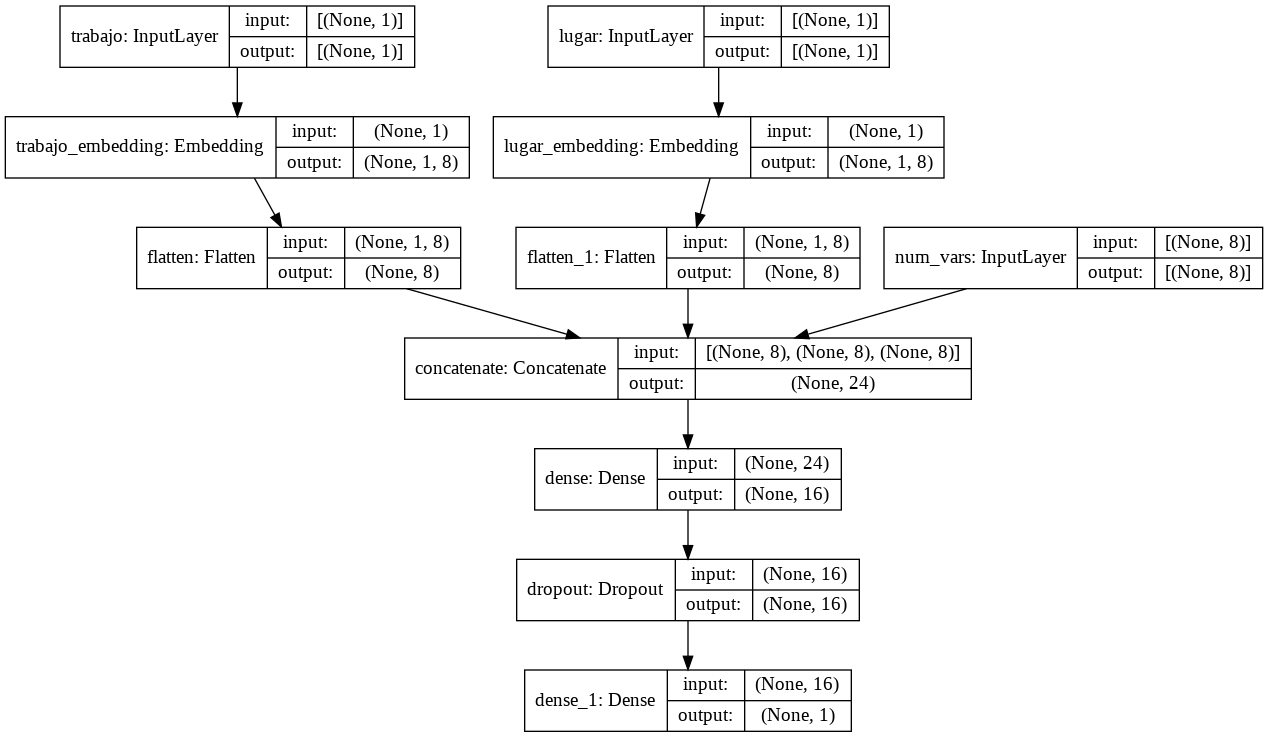

In [71]:
keras.utils.plot_model(model_final, show_shapes=True)

### Network training and fitting

Defining a variable learning rate

In [72]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000, # train cases/ batch size
    decay_rate=0.9, 
    staircase=False)

In [73]:
model_final.compile(optimizer= keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='MSE',
              metrics='MAE')

Fit

In [74]:
history = model_final.fit(x=[x_train_trabajo, x_train_lugar, x_train], y=y_train, epochs=50, batch_size=8, validation_split=0.2)

Epoch 1/50
653/653 [==============================] - 2s 2ms/step - loss: 0.0603 - MAE: 0.1940 - val_loss: 0.0569 - val_MAE: 0.1836
Epoch 2/50
653/653 [==============================] - 1s 1ms/step - loss: 0.0548 - MAE: 0.1817 - val_loss: 0.0534 - val_MAE: 0.1817
Epoch 3/50
653/653 [==============================] - 1s 2ms/step - loss: 0.0513 - MAE: 0.1754 - val_loss: 0.0566 - val_MAE: 0.1847
Epoch 4/50
653/653 [==============================] - 1s 2ms/step - loss: 0.0522 - MAE: 0.1739 - val_loss: 0.0539 - val_MAE: 0.1809
Epoch 5/50
653/653 [==============================] - 1s 2ms/step - loss: 0.0513 - MAE: 0.1736 - val_loss: 0.0523 - val_MAE: 0.1771
Epoch 6/50
653/653 [==============================] - 1s 1ms/step - loss: 0.0485 - MAE: 0.1682 - val_loss: 0.0523 - val_MAE: 0.1806
Epoch 7/50
653/653 [==============================] - 1s 1ms/step - loss: 0.0494 - MAE: 0.1699 - val_loss: 0.0523 - val_MAE: 0.1812
Epoch 8/50
653/653 [==============================] - 1s 2ms/step - loss: 0.

Plotting errors

In [76]:
fig1,fig2=plot_all(history, 'MAE')
fig1.show()
fig2.show()

From this graphics, i see that there is a very little overfitting. The oscillation is caused by the decay in the learning rate.

### Sanity check / Validation


Predictions

In [77]:
y_pred_train = model_final.predict([x_train_trabajo, x_train_lugar, x_train]).flatten()
y_pred_test = model_final.predict([x_test_trabajo, x_test_lugar, x_test]).flatten()

In [78]:
print('tr: ', round(np.mean(abs(y_pred_train-y_train)),3), 'ts: ',round(np.mean(abs(y_pred_test-y_test)),3))

tr:  0.234 ts:  0.284


The errors are very similar.

<h3>Result analysis</h3>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffaa17a8be0>]],
      dtype=object)

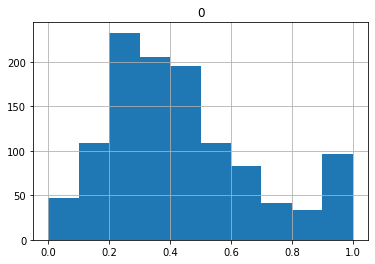

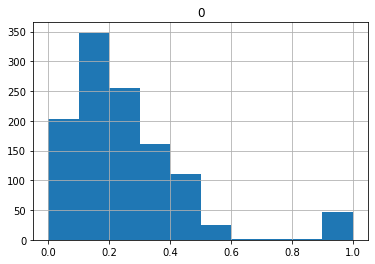

In [79]:
todf(y_test).hist()
todf(y_pred_test).hist()

The distributions are very similar 

<h3>Output distribution analysis</h3>

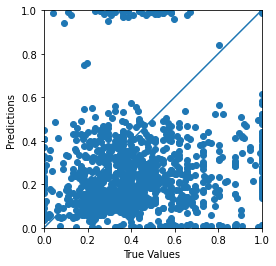

In [80]:
a = plt.axes(aspect='equal')
plt.scatter(y_test[:,0], y_pred_test)
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

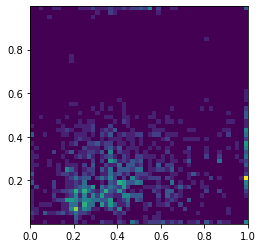

In [81]:
heatmap, xedges, yedges = np.histogram2d(y_test[:,0], y_pred_test, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

From this graphic, i see that the model performs very well between 0 and 0.6. For bigger values, the density is very low.

### Insights

In this notebook, i created a neural network using different data types as input, in which two of the three variables were high cardinality variables, so, i followed the embedding approach. When creating the model, i used a decaying learning rate approach, that improves the performance model. Finally, validating the model, i saw that for some values the model performs very well but not for other, so, some changes will be applied in the future.